In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# path = '/content/drive/MyDrive/Research/AAAI/dataset2/Arch2/zeroth_layer_with_entropy/k_01/'

In [3]:
pip install sparsemax

In [4]:
import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


from sparsemax import Sparsemax

from matplotlib import pyplot as plt
%matplotlib inline

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Generate dataset

In [6]:
mu1 = np.array([3,3,3,3,0])
sigma1 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu2 = np.array([4,4,4,4,0])
sigma2 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu3 = np.array([10,5,5,10,0])
sigma3 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu4 = np.array([-10,-10,-10,-10,0])
sigma4 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu5 = np.array([-21,4,4,-21,0])
sigma5 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu6 = np.array([-10,18,18,-10,0])
sigma6 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu7 = np.array([4,20,4,20,0])
sigma7 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu8 = np.array([4,-20,-20,4,0])
sigma8 = np.array([[16,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu9 = np.array([20,20,20,20,0])
sigma9 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

mu10 = np.array([20,-10,-10,20,0])
sigma10 = np.array([[1,1,1,1,1],[1,16,1,1,1],[1,1,1,1,1],[1,1,1,1,1],[1,1,1,1,1]])

In [7]:
np.random.seed(12)
sample1 = np.random.multivariate_normal(mean=mu1,cov= sigma1,size=500)
sample2 = np.random.multivariate_normal(mean=mu2,cov= sigma2,size=500)
sample3 = np.random.multivariate_normal(mean=mu3,cov= sigma3,size=500)
sample4 = np.random.multivariate_normal(mean=mu4,cov= sigma4,size=500)
sample5 = np.random.multivariate_normal(mean=mu5,cov= sigma5,size=500)
sample6 = np.random.multivariate_normal(mean=mu6,cov= sigma6,size=500)
sample7 = np.random.multivariate_normal(mean=mu7,cov= sigma7,size=500)
sample8 = np.random.multivariate_normal(mean=mu8,cov= sigma8,size=500)
sample9 = np.random.multivariate_normal(mean=mu9,cov= sigma9,size=500)
sample10 = np.random.multivariate_normal(mean=mu10,cov= sigma10,size=500)

In [8]:
X = np.concatenate((sample1,sample2,sample3,sample4,sample5,sample6,sample7,sample8,sample9,sample10),axis=0)
Y = np.concatenate((np.zeros((500,1)),np.ones((500,1)),2*np.ones((500,1)),3*np.ones((500,1)),4*np.ones((500,1)),
                    5*np.ones((500,1)),6*np.ones((500,1)),7*np.ones((500,1)),8*np.ones((500,1)),9*np.ones((500,1))),axis=0).astype(int)

In [9]:
print(X[0], Y[0])

[ 2.20218134  1.32290141  2.20218134  2.20218134 -0.79781866] [0]


In [10]:
print(X[500], Y[500])

[12.65418869  5.7937588   5.7937588   5.7937588   1.7937588 ] [1]


In [11]:
class SyntheticDataset(Dataset):
  """MosaicDataset dataset."""
  def __init__(self, x, y):
    """
      Args:
       x: list of instance
       y: list of instance label
    """
    self.x = x
    self.y = y
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx] , self.y[idx] #, self.fore_idx[idx]

trainset = SyntheticDataset(X,Y)

classes = ('zero','one','two','three','four','five','six','seven','eight','nine')

foreground_classes = {'zero','one','two'}
fg_used = '012'
fg1, fg2, fg3 = 0,1,2

all_classes = {'zero','one','two','three','four','five','six','seven','eight','nine'}
background_classes = all_classes - foreground_classes
print("background classes ",background_classes)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

dataiter = iter(trainloader)
background_data=[]
background_label=[]
foreground_data=[]
foreground_label=[]
batch_size=100

for i in range(50):
  images, labels = dataiter.next()
  for j in range(batch_size):
    if(classes[labels[j]] in background_classes):
      img = images[j].tolist()
      background_data.append(img)
      background_label.append(labels[j])
    else:
      img = images[j].tolist()
      foreground_data.append(img)
      foreground_label.append(labels[j])
            
foreground_data = torch.tensor(foreground_data)
foreground_label = torch.tensor(foreground_label)
background_data = torch.tensor(background_data)
background_label = torch.tensor(background_label)

background classes  {'seven', 'three', 'five', 'six', 'four', 'eight', 'nine'}


In [12]:
print(foreground_data[0], foreground_label[0] )

tensor([ 2.2022,  1.3229,  2.2022,  2.2022, -0.7978]) tensor(0)


In [13]:
def create_mosaic_img(bg_idx,fg_idx,fg): 
  """
  bg_idx : list of indexes of background_data[] to be used as background images in mosaic
  fg_idx : index of image to be used as foreground image from foreground data
  fg : at what position/index foreground image has to be stored out of 0-8
  """
  image_list=[]
  j=0
  for i in range(9):
    if i != fg:
      image_list.append(background_data[bg_idx[j]])
      j+=1
    else: 
      image_list.append(foreground_data[fg_idx])
      label = foreground_label[fg_idx] - fg1  # minus fg1 because our fore ground classes are fg1,fg2,fg3 but we have to store it as 0,1,2
  #image_list = np.concatenate(image_list ,axis=0)
  image_list = torch.stack(image_list) 
  return image_list,label

In [14]:
desired_num = 6000
mosaic_list_of_images =[]      # list of mosaic images, each mosaic image is saved as list of 9 images
fore_idx =[]                   # list of indexes at which foreground image is present in a mosaic image i.e from 0 to 9               
mosaic_label=[]                # label of mosaic image = foreground class present in that mosaic
list_set_labels = [] 
for i in range(desired_num):
  set_idx = set()
  np.random.seed(i)
  bg_idx = np.random.randint(0,3500,8)
  set_idx = set(background_label[bg_idx].tolist())
  fg_idx = np.random.randint(0,1500)
  set_idx.add(foreground_label[fg_idx].item())
  fg = np.random.randint(0,9)
  fore_idx.append(fg)
  image_list,label = create_mosaic_img(bg_idx,fg_idx,fg)
  mosaic_list_of_images.append(image_list)
  mosaic_label.append(label)
  list_set_labels.append(set_idx)

In [15]:
len(mosaic_list_of_images), mosaic_list_of_images[0]

(6000, tensor([[ 20.0825,  25.5012,  20.0825,  20.0825,   0.0825],
         [ 20.6911,  22.6202,  20.6911,  20.6911,   0.6911],
         [  1.2544,  22.0426,   6.0426,  22.0426,   2.0426],
         [  9.2862,   3.1005,   4.2862,   9.2862,  -0.7138],
         [ 20.7622, -12.2787,  -9.2378,  20.7622,   0.7622],
         [-27.2336,   3.4770,   3.4770, -21.5230,  -0.5230],
         [-32.2853,   1.7774,   1.7774, -23.2226,  -2.2226],
         [  4.1916,  17.4376,   1.4376,  17.4376,  -2.5624],
         [ 20.9615,  -4.3890,  -9.0385,  20.9615,   0.9615]]))

In [16]:
np.shape(mosaic_list_of_images[0])

torch.Size([9, 5])

# load mosaic data

In [17]:
class MosaicDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [18]:
batch = 250
msd1 = MosaicDataset(mosaic_list_of_images[0:3000], mosaic_label[0:3000] , fore_idx[0:3000])
train_loader = DataLoader( msd1 ,batch_size= batch ,shuffle=True)

In [19]:
batch = 250
msd2 = MosaicDataset(mosaic_list_of_images[3000:6000], mosaic_label[3000:6000] , fore_idx[3000:6000])
test_loader = DataLoader( msd2 ,batch_size= batch ,shuffle=True)

# models

In [20]:
class my_spherical_softmax(nn.Module):
    """
    implementation is taken from https://github.com/anirbanl/sparsegen 
    Code for the NeurIPS 2018 paper "On Controllable Sparse Alternatives to Softmax"
    """
    def __init__(self):
        super(my_spherical_softmax,self).__init__()
    def forward(self,x):
        bs = x.data.size()[0]
        dim = x.data.size()[1]
        z = torch.pow(x, 2)
        z_sum = torch.sum(z, dim=1).view(bs, 1).repeat(1, dim)
        return z/z_sum

In [21]:
class Focus_deep(nn.Module):
    '''
       deep focus network averaged at zeroth layer with input-6-12-output architecture
       input : elemental data
    '''
    def __init__(self,inputs,output,K,d):
        super(Focus_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.K = K
        self.d  = d
        self.linear1 = nn.Linear(self.inputs,6, bias=False)  #,self.output)
        self.linear2 = nn.Linear(6,12, bias=False)
        self.linear3 = nn.Linear(12,self.output, bias=False) 

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        #self.sparsemax = Sparsemax(dim=-1) 
        self.spherical_softmax = my_spherical_softmax()


    def forward(self,z):
        #print("data",z)
        batch = z.shape[0]
        x = torch.zeros([batch,self.K],dtype=torch.float64)
        y = torch.zeros([batch,5], dtype=torch.float64)   # number of features of output
        features = torch.zeros([batch,self.K,5],dtype=torch.float64)
        x,y = x.to(device),y.to(device)
        features = features.to(device)
        for i in range(self.K):
            alp,ftrs = self.helper(z[:,i] )  # required only when mosaic data is of d*k dimension self.d*i:self.d*i+self.d
            x[:,i] = alp[:,0]   # preactivation alphas 
            features[:,i]  = ftrs  # averaging over these features
        


        #x = F.softmax(x,dim=1)   # alphas
        #print("softmax",F.softmax(x,dim=1))
        #print("sparsemax",self.sparsemax(x))
        #x = F.softmax(x,dim=1)
        #x = self.sparsemax(x)   # alphas
        x = self.spherical_softmax(x)

        
        for i in range(self.K):
            x1 = x[:,i]          
            y = y+torch.mul(x1[:,None],features[:,i])  # self.d*i:self.d*i+self.d
        return y , x   # return attended data, alpha values
    def helper(self,x):
      x1 = x
      x = self.linear1(x)
      x = F.relu(x) 
      x = self.linear2(x)
      x = F.relu(x)
      x = self.linear3(x)
      return x,x1

In [22]:
fc = Focus_deep(5,1,9,5).double()
fc = fc.to("cuda")

In [23]:
fc(torch.randn((2,9,5)).double().to("cuda"))

(tensor([[ 1.1468,  0.4774,  1.2228, -0.6848, -0.4079],
         [ 0.6235, -0.7488,  0.3877, -0.6314, -0.9930]], device='cuda:0',
        dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor([[2.0371e-01, 4.7536e-04, 1.8255e-01, 1.4091e-01, 3.9403e-01, 1.3372e-02,
          5.6678e-02, 8.2693e-03, 0.0000e+00],
         [4.8973e-01, 0.0000e+00, 5.2496e-03, 2.6879e-02, 1.2531e-04, 3.9942e-05,
          9.7133e-04, 6.8976e-02, 4.0803e-01]], device='cuda:0',
        dtype=torch.float64, grad_fn=<DivBackward0>))

In [24]:
class Classification_deep(nn.Module):
    '''
       input : elemental data
       deep classification module data averaged at zeroth layer with architecture input-6-12-output
    '''
    def __init__(self,inputs,output):
        super(Classification_deep,self).__init__()
        self.inputs = inputs
        self.output = output
        self.linear1 = nn.Linear(self.inputs,6)
        self.linear2 = nn.Linear(6,12)
        self.linear3 = nn.Linear(12,self.output)

        torch.nn.init.xavier_normal_(self.linear1.weight)
        torch.nn.init.zeros_(self.linear1.bias)
        torch.nn.init.xavier_normal_(self.linear2.weight)
        torch.nn.init.zeros_(self.linear2.bias)
        torch.nn.init.xavier_normal_(self.linear3.weight)
        torch.nn.init.zeros_(self.linear3.bias)

    def forward(self,x):
      x = F.relu(self.linear1(x))
      x = F.relu(self.linear2(x))
      x = self.linear3(x)
      return x

In [25]:
criterion = nn.CrossEntropyLoss()
# def my_cross_entropy(x, y,alpha,log_alpha,k):
#     # log_prob = -1.0 * F.log_softmax(x, 1)
#     # loss = log_prob.gather(1, y.unsqueeze(1))
#     # loss = loss.mean()
#     loss = criterion(x,y)
    
#     #alpha = torch.clamp(alpha,min=1e-10)     
    
#     b = -1.0* alpha * log_alpha
#     b =  torch.mean(torch.sum(b,dim=1))
#     closs = loss
#     entropy = b 
#     loss = (1-k)*loss + ((k)*b)
#     return loss,closs,entropy

In [26]:
def calculate_attn_loss(dataloader,what,where,criter):
  what.eval()
  where.eval()
  r_loss = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")



      avg,alpha = where(inputs)
      outputs = what(avg)
      
      
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      loss = criter(outputs,labels)
      r_loss += loss.item()


  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,analysis

In [27]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    # value>0.01
    sparsity_val = np.sum(np.sum(alphas>0.01,axis=1))
    # simplex distance
    argmax_index = np.argmax(alphas,axis=1)
    simplex_pt = np.zeros(alphas.shape)
    simplex_pt[np.arange(argmax_index.size),argmax_index] = 1
    
    shortest_distance_simplex = np.sum(np.sqrt(np.sum((alphas-simplex_pt)**2,axis=1))) 
    
    # entropy
    #entropy = np.nansum((-alphas*np.log2(alphas)).sum(axis=1))
    entropy = np.sum(np.nansum(-alphas*np.log2(alphas),axis=1))  


    return [ftpt,ffpt,ftpf,ffpf,sparsity_val,shortest_distance_simplex,entropy]#,amth,alth]

# training

In [28]:
number_runs = 5
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF","sparsity_value","shortest distance smplx","Entropy"])

for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Focus_deep(5,1,9,5).double()
  # where.linear2.weight.data[6:,:] = where.linear2.weight.data[:6,:]
  # where.linear3.weight.data[:,6:] = -where.linear3.weight.data[:,:6]
  where = where.double().to("cuda")


  what = Classification_deep(5,3).double()
  where = where.to("cuda")
  what = what.to("cuda")

  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 2500


  # calculate zeroth epoch loss and FTPT values
  running_loss ,anlys_data= calculate_attn_loss(train_loader,what,where,criterion)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha = where(inputs)
      outputs = what(avg)

      loss = criterion(outputs,labels)

      # print statistics
      loss.backward()
      optimizer_where.step()
      optimizer_what.step()
      running_loss +=  loss.item()
    #break
    running_loss,anls_data = calculate_attn_loss(train_loader,what,where,criterion)
    analysis_data.append(anls_data)

    if(epoch % 200==0):
      print('epoch: [%d] loss: %.3f ' %(epoch + 1,running_loss)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.01:
      print('breaking in epoch: ', epoch)
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:7]/3000
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in test_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 test images: %f %%' % (  100 * correct / total))
    

--------------------------------------------------------------------------------
epoch: [0 ] loss: 7.674
epoch: [1] loss: 4.444 
epoch: [201] loss: 0.701 
epoch: [401] loss: 0.232 
epoch: [601] loss: 0.231 
epoch: [801] loss: 0.242 
epoch: [1001] loss: 0.138 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in log2
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: RuntimeWarning: invalid value encountered in multiply


epoch: [1201] loss: 0.062 
epoch: [1401] loss: 0.189 
epoch: [1601] loss: 0.167 
epoch: [1801] loss: 0.077 
epoch: [2001] loss: 0.249 
epoch: [2201] loss: 0.061 
epoch: [2401] loss: 0.053 
Finished Training run 0
Accuracy of the network on the 3000 test images: 98.300000 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.821
epoch: [1] loss: 1.369 
epoch: [201] loss: 1.179 
epoch: [401] loss: 1.176 
epoch: [601] loss: 0.515 
epoch: [801] loss: 0.386 
epoch: [1001] loss: 0.184 
epoch: [1201] loss: 0.150 
epoch: [1401] loss: 0.182 
epoch: [1601] loss: 0.136 
epoch: [1801] loss: 0.237 
epoch: [2001] loss: 0.097 
epoch: [2201] loss: 0.065 
epoch: [2401] loss: 0.168 
Finished Training run 1
Accuracy of the network on the 3000 test images: 97.900000 %
--------------------------------------------------------------------------------
epoch: [0 ] loss: 1.878
epoch: [1] loss: 1.441 
epoch: [201] loss: 1.198 
epoch: [401] loss: 0.691 
epoch: [601

In [29]:
print(np.mean(np.array(FTPT_analysis),axis=0)) 

[4.20733333e-01 3.90466667e-01 2.26666667e-03 1.86533333e-01
 3.74360000e+00 3.49637990e-01 1.10595707e+00]


In [30]:
0.917+0.0816

0.9986

In [31]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF,sparsity_value,shortest distance smplx,Entropy
0,0.623000,0.362333,0.001333,0.013333,2.994333,0.238824,0.742113
1,0.643667,0.340000,0.001333,0.015000,2.499667,0.209293,0.630045
2,0.350333,0.500333,0.008333,0.141000,3.024667,0.281567,0.844857
3,0.486667,0.346000,0.000333,0.167000,4.052333,0.332867,1.122563
4,0.000000,0.403667,0.000000,0.596333,6.147000,0.685639,2.190208


In [36]:
FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 0.9 ]

,FTPT,FFPT,FTPF,FFPF,sparsity_value,shortest distance smplx,Entropy
0,0.623000,0.362333,0.001333,0.013333,2.994333,0.238824,0.742113
1,0.643667,0.340000,0.001333,0.015000,2.499667,0.209293,0.630045


In [37]:
print(np.mean(np.array(FTPT_analysis[FTPT_analysis['FTPT']+FTPT_analysis['FFPT'] > 0.9 ]),axis=0))

[6.33333333e-01 3.51166667e-01 1.33333333e-03 1.41666667e-02
 2.74700000e+00 2.24058787e-01 6.86078630e-01]


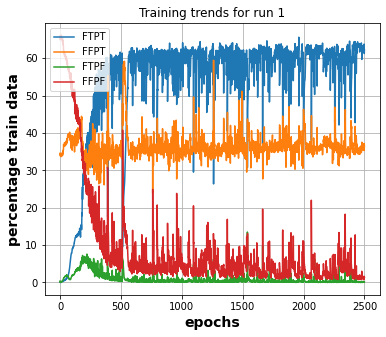

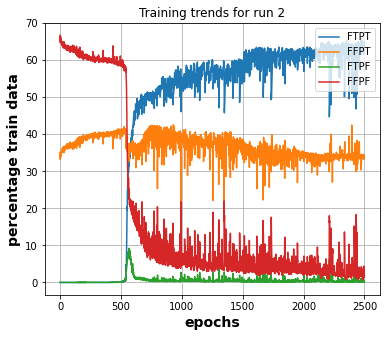

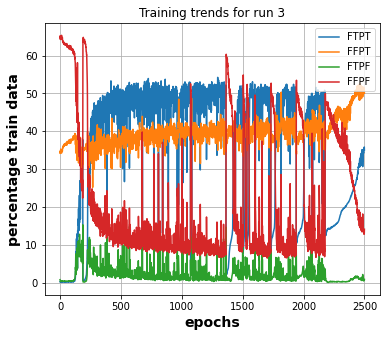

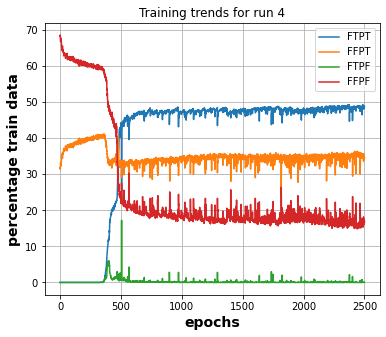

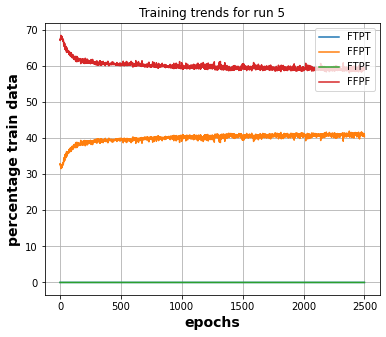

In [34]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,5))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0]/30,label="FTPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1]/30,label="FFPT")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2]/30,label="FTPF")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3]/30,label="FFPF")

  plt.title("Training trends for run "+str(cnt))
  plt.grid()
  # plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.legend()
  plt.xlabel("epochs", fontsize=14, fontweight = 'bold')
  plt.ylabel("percentage train data", fontsize=14, fontweight = 'bold')
  #plt.savefig(path + "run"+str(cnt)+".png",bbox_inches="tight")
  #plt.savefig(path + "run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1

In [35]:
#FTPT_analysis.to_csv(path+"synthetic_zeroth.csv",index=False)